# 第 2 章：消息传递范式

消息传递是实现 GNN 的一种通用框架和编程范式。它从聚合与更新的角度归纳总结了多种 GNN 模型的实现。


 消息传递范式 

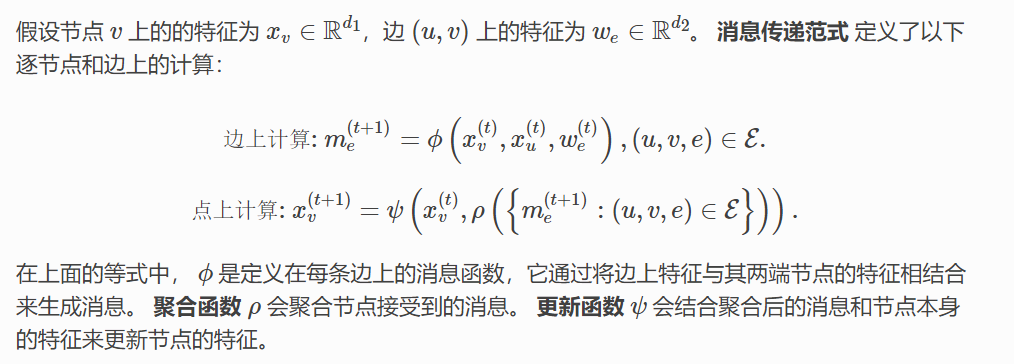

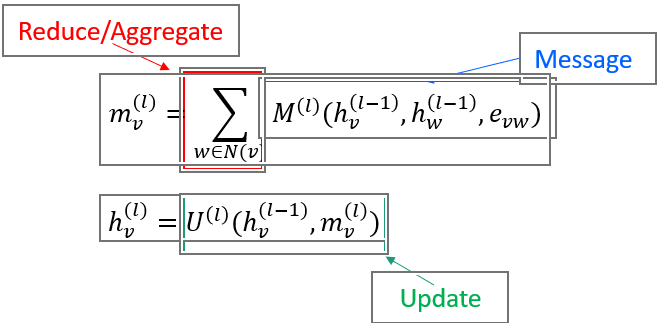

## 2.1 内置函数和消息传递 API

- 聚合函数 
1. 接受一个参数 nodes.
2. nodes 的成员属性 mailbox 可以用来访问节点收到的消息。
3. 一些最常见的聚合操作包括 sum、max、min 等
- 更新函数 
1. 接受一个如上所述的参数 nodes
2. 此函数对 聚合函数 的聚合结果进行操作；
3. 通常在消息传递的最后一步将其与节点的特征相结合，并将输出作为节点的新特征。

dgl.function 中实现了常用的消息函数和聚合函数作为 内置函数。 一般来说，DGL 建议 尽可能 使用内置函数。用户的消息传递函数无法用内置函数实现，则可以实现自己的消息或聚合函数 (也称为 用户定义函数)

- 内置消息函数可以是一元函数或二元函数。
 1. 对于**一元函数**，DGL 支持 copy 函数。
 2. 对于**二元函数**， DGL 现在支持 add、 sub、 mul、 div、 dot 函数。
 3. 消息的内置函数的命名约定是 u 表示源节点，v 表示目标节点，e表示边。

例1
---
 要对源节点的 $hu$ 特征和目标节点的 $hv$ 特征求和， 然后将结果保存在边的 $he$ 特征上，用户可以使用内置函数 *dgl.function.u_add_v('hu', 'hv', 'he')*。 而以下用户定义消息函数与此内置函数等价

`def message_func(edges):
     return {'he': edges.src['hu'] + edges.dst['hv']}`

**聚合函数**

DGL 支持内置的聚合函数 sum、 max、 min 和 mean 操作。 聚合函数通常有两个参数，它们的类型都是字符串。

- 一个用于指定 mailbox 中的字段名
-  一个用于指示目标节点特征的字段名

例2
---
 *dgl.function.sum('m', 'h')*等价于如下所示的对接收到消息求和的用户定义函数：

`import torch
def reduce_func(nodes):
     return {'h': torch.sum(nodes.mailbox['m'], dim=1)}`

### update_all()

update_all() 的参数是一个消息函数、一个聚合函数和一个更新函数。

 更新函数是一个可选择的参数，用户可以不使用它

In [5]:
def update_all_example(graph):
    # 在graph.ndata['ft']中存储结果
    graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                     fn.sum('m', 'ft'))
    # 在update_all外调用更新函数
    final_ft = graph.ndata['ft'] * 2
    return final_ft

此调用通过将源节点特征$ft$ 与边特征$a$ 相乘生成消息 $m$， 然后对所有消息求和来更新节点特征$ft$，再将 $ft$ 乘以 2 得到最终结果 final_ft。

 $$\text { final_ft }_i=2 * \sum_{j \in \mathcal{N}(i)}\left(f t_j * a_{i j}\right)$$

## 2.2 编写高效的消息传递代码 (高效的自己定义用户函数)

 - 优化内存
 - 线性层拆分

 ## 2.3在图的一部分上进行消息传递

如果用户只想更新图中的部分节点，可以先通过想要囊括的节点编号创建一个子图， 然后在子图上调用 update_all() 方法。

`nid = [0, 2, 3, 6, 7, 9]
sg = g.subgraph(nid)
sg.update_all(message_func, reduce_func, apply_node_func)`

## 2.4 在异构图上进行消息传递

异构图上的消息传递可以分为两个部分：

1. 对每个关系计算和聚合消息。

2. 对每个结点聚合来自不同关系的消息。

在 DGL 中，对异构图进行消息传递的接口是 multi_update_all()。 
- multi_update_all() 接受一个字典。这个字典的每一个键值对里，键是一种关系， 值是这种关系对应 update_all() 的参数。
-  multi_update_all() 还接受一个字符串来表示跨类型整合函数，来指定整合不同关系聚合结果的方式。 这个整合方式可以是 sum、 min、 max、 mean 和 stack 中的一个。

In [8]:
def kub(): # 不能执行
    import dgl.function as fn
    for c_etype in G.canonical_etypes:
        srctype, etype, dsttype = c_etype
        Wh = self.weight[etype](feat_dict[srctype])
        # 把它存在图中用来做消息传递
        G.nodes[srctype].data['Wh_%s' % etype] = Wh
        # 指定每个关系的消息传递函数：(message_func, reduce_func).
        # 注意结果保存在同一个目标特征“h”，说明聚合是逐类进行的。
        funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
    # 将每个类型消息聚合的结果相加。
    G.multi_update_all(funcs, 'sum')
    # 返回更新过的节点特征字典
    return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}